# Is Sympy really 'slow'?
I don't want to be a bad carpenter who blames his tools. Here're my attempts at understanding why my Sympy code is slow. The technical specs of my computer may have a lot to do with the long time things are taking to run, though, any techniques I discover to speed up computation will have a speed up on any system I suppose. 

Ultimately my goal is to have integral and linear algebra routines that can run at sub-second speed, and preferrably a few ms. 

## Potential things to try out 

* ~~I may have been using the wrong Python version of Theano. The [docs](https://theano-pymc.readthedocs.io/en/latest/requirements.html) say official support for Theano is only there for Python <3.6.~~ 
    * ~~install Sympy, Theano nd pyMC3~~ *This doesn't work because Theano didn't seem to recognise 'external' sympy functions, eg. legendre*
    
* With ```lambdify``` use the 'mpmath' module as a backend. This *really* sped up computations, in comparison to the default (sympy?) backend module. 

* ~~Linux specific: change the 'niceness'of the process and so the CPU spends more time on the code.~~~

## Latest realisation
* I've been using the 'normal' Hankel function instead of the spherical Hankel function. This is probably the main reason why my results are off all the time!!!!!

In [1]:
#from joblib import Parallel, delayed
#from joblib import wrap_non_picklable_objects
from gmpy2 import *
import matplotlib.pyplot as plt
import mpmath
from mpmath import mpf
dps = 50; mpmath.mp.dps = dps
import numpy as np
#from scipy.special import jv as bessel_firstkind
from symengine import * 
import sympy
from sympy import jn,yn ,symbols, legendre, sin, cos, tan, summation, I, oo, diff, pi, sqrt
from sympy import factor_terms, Matrix, besselj, bessely, Piecewise
from sympy import Abs, lambdify, integrate, expand,integrate, Integral
from sympy.printing.theanocode import theano_function
from sympy.utilities.autowrap import autowrap
import tqdm
x, alpha, gamma, index, k, m,n,p, r1, R, theta, y, z = symbols('x alpha gamma index k m n p r1 R theta,y,z')
from sympy import N, cse

from sympy.printing.theanocode import theano_function
num_sumterms = 50

In [2]:
from sympy import besselj

In [3]:
sph_bessel1 = besselj(n+1/2,z)*sqrt(pi/(2*z))
sph_bessel2 = bessely(n+1/2,z)*sqrt(pi/(2*z))
sph_hankel2 = sph_bessel1 - I*sph_bessel2
#sph_hankel2 = lambdify([n, p], sph_bessel1(n,p)-I*sph_bessel2(n,p), 'mpmath')

In [4]:
sqrt(pi/(2*z))

sqrt(2)*sqrt(pi)*sqrt(1/z)/2

In [5]:
r1 = (R*cos(alpha))/cos(theta)

In [6]:
subs_dict = {'alpha':mpmath.pi/18, 'k':5,'R':mpf(0.1), 'm':20,'n':10}

In [7]:
Lm_expr = legendre(m,cos(theta))*(r1**2/R**2)*tan(theta)
Lm = Integral(Lm_expr, (theta,0,alpha))#.doit(meijerg=True)
Lmexpr_func = lambdify([m, R, alpha,theta], Lm_expr, 'mpmath')
Lm_func = lambdify([m, R, alpha], Lm, 'mpmath') # numerical integrtion of eqn. 12.108

In [8]:
# eqn 12.107
Kmn_expr = legendre(n, cos(theta))*legendre(m, cos(theta))*sin(theta) # the integrl of this expression 
# has a solution given in Appendix II, eqn 70
legendre_1stderiv = diff(legendre(n,z),z)
# when m != n
num_legendre_term1 = legendre(m,cos(alpha))*legendre_1stderiv.subs({'z':cos(alpha)})
num_legendre_term2 = legendre(n,cos(alpha))*legendre_1stderiv.subs({'n':m,'z':cos(alpha)})
eqn70_mnoteqn = sin(alpha)*(num_legendre_term1-num_legendre_term2)/(m*(m+1)-n*(n+1))

# when m==n
summn_funcn = legendre(index,cos(alpha))*(legendre(index,cos(alpha))*cos(alpha)-legendre(index+1,cos(alpha)))
# substituting 'j' for 'index' because j is also used for sqrt(-1) all through the book!!

meqn_sumterm = 2*summation(summn_funcn, (index,1,m-1))
eqn70_meqn = (1+ cos(alpha)*legendre(m,cos(alpha))**2 + meqn_sumterm)/(2*m+1)

In [9]:
Kmn = Piecewise((eqn70_mnoteqn,m>n),(eqn70_mnoteqn,m<n), (eqn70_meqn,True), )
Kmn_func = lambdify([m,n,alpha],Kmn,'mpmath')

In [10]:
Kmn

Piecewise(((-m*(cos(alpha)*legendre(m, cos(alpha)) - legendre(m - 1, cos(alpha)))*legendre(n, cos(alpha))/(cos(alpha)**2 - 1) + n*(cos(alpha)*legendre(n, cos(alpha)) - legendre(n - 1, cos(alpha)))*legendre(m, cos(alpha))/(cos(alpha)**2 - 1))*sin(alpha)/(m*(m + 1) - n*(n + 1)), (m > n) | (m < n)), ((cos(alpha)*legendre(m, cos(alpha))**2 + 2*Sum((cos(alpha)*legendre(index, cos(alpha)) - legendre(index + 1, cos(alpha)))*legendre(index, cos(alpha)), (index, 1, m - 1)) + 1)/(2*m + 1), True))

In [11]:

alternate_hankels = n*sph_hankel2.subs({'n':n-1, 'z':k*r1})-(n+1)*sph_hankel2.subs({'n':n+1, 'z':k*r1})
pt1_postterm = legendre(n,cos(theta))*cos(theta)
Imn_pt1 = alternate_hankels*pt1_postterm

pt2_preterm = n*(n+1)*sph_hankel2.subs({'z':k*r1})
alternate_legendres = (legendre(n-1,cos(theta))-legendre(n+1,cos(theta)))/(k*r1)
Imn_pt2 = pt2_preterm*alternate_legendres

whole_postterm = legendre(m,cos(theta))*(r1**2/R**2)*tan(theta)

Imn_term = (Imn_pt1 + Imn_pt2)*whole_postterm # eqn. 12.106
Imn = Integral(Imn_term,(theta,0,alpha))
Imn_term_func = lambdify([m,n,k,R,alpha,theta], Imn_term, 'mpmath')
Imn_func = lambdify([m,n,k,R,alpha],Imn,'mpmath') 


In [12]:

def imn_quad_value(params):
    variables = ['m','n','k','R','alpha']    
    imn_onlytheta = Imn_term.subs({each: params[each] for each in variables})
    imn_onlytheta_f = lambdify([theta],imn_onlytheta,'mpmath')
    # try breaking 0-alpha into 10 parts if the error is  too high - with mpmath.linspace?
    return mpmath.quad(imn_onlytheta_f,[0,params['alpha']],error=True)

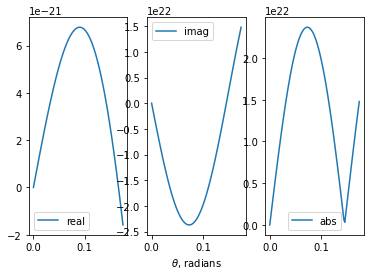

In [13]:
mv,nv = 2,15
npts = 100
imn_values = mpmath.matrix(1,npts)
angles = np.linspace(0,float(subs_dict['alpha']),npts)
for i,each in enumerate(angles):
    imn_values[i] = Imn_term_func(mv,nv,subs_dict['k'],subs_dict['R'],subs_dict['alpha'],each)
real_imn = [each.real for each in imn_values]
imag_imn = [each.imag for each in imn_values]
abs_imn = [abs(each) for each in imn_values]

plt.figure()
plt.subplot(131)
plt.plot(angles, real_imn,label='real');plt.legend()
plt.subplot(132)
plt.plot(angles, imag_imn,label='imag');plt.legend()
plt.xlabel('$\\theta$, radians')
plt.subplot(133)
plt.plot(angles, abs_imn,label='abs');plt.legend()


### Broadly speaking, the Imn function is fairly smooth, and so numerical integration shouldn't be such a problem?

In [14]:
frequency = 50*10**3 # kHz
vsound = 330 # m/s
wavelength = vsound/frequency
alpha_value = mpmath.pi/3 # 60 degrees --> pi/3
k_value = 2*mpmath.pi/(wavelength)
ka = 10
a_value = ka/k_value 
R_value = a_value/mpmath.sin(alpha_value) # m


In [15]:
Nv = 12 + int(2*ka/sin(alpha_value))
M_matrix = mpmath.matrix(Nv,Nv)
b_matrix = mpmath.matrix(Nv,1)



In [16]:
b = -I*Lm
b_func = lambdify([m,alpha], b,'mpmath') # eqn. 12.104

In [17]:
params = {'k':k_value, 'a':a_value, 'R':R_value, 'alpha':alpha_value}

In [18]:
mmn_hankels = n*sph_hankel2.subs({'n':n-1,'z':k*R})-(n+1)*sph_hankel2.subs({'n':n+1,'z':k*R})
mmn_hankels_func = lambdify([n,k,R], mmn_hankels,'mpmath')

In [19]:
all_quaderrors = []
for i in tqdm.trange(Nv):
    for j in range(Nv):
        params['m'],params['n'] = i,j
        Imn_value = Imn_func(params['m'], params['n'],params['k'],params['R'],params['alpha'])
        Kmn_value = Kmn_func(params['m'],params['n'],params['alpha'])
        numerator_hankels = mmn_hankels_func(j,params['k'],params['R'])
        numerator = Imn_value+ numerator_hankels*Kmn_value
        denom = 2*params['n']+1
        M_matrix[params['m'],params['n']] = numerator/denom


100%|██████████| 35/35 [38:08<00:00, 65.37s/it]


In [20]:
all_quaderrors

[]

In [21]:
for each_m in range(Nv):
    #M_matrix[each_m, each_n] = M_mn_func(each_m, each_n, k_value, R_value, alpha_value)
    b_matrix[each_m,:] = b_func(each_m, alpha_value)

In [22]:
a_matrix = mpmath.inverse(M_matrix)*b_matrix

In [23]:
legendre_func = lambdify((m, x), legendre(m, x),'mpmath')

In [24]:
#summn_term = A_n[index]*(I**index)*legendre(index,mpmath.cos(theta))
#summn_value = summation(summn_term, (index,0,N_v))


def d_theta(angle,k_v,R_v,alpha_v,An):
    num = 4 
    N_v = An.rows
    denom  = (k_v**2)*(R_v**2)*mpmath.sin(alpha_v)**2
    part1 = num/denom
    jn_matrix = np.array([1j**f for f in range(N_v)])
    legendre_matrix = mpmath.matrix([legendre(n_v, mpmath.cos(angle)) for n_v in range(N_v)])
    part2_matrix = np.column_stack((An, jn_matrix, legendre_matrix))
    part2 = np.sum(np.apply_along_axis(lambda X: X[0]*X[1]*X[2], 1, part2_matrix))
    
    rel_level = - part1*part2
    return rel_level

def d_zero(k_v,R_v,alpha_v,An):
    num = 4 
    N_v = An.rows
    denom  = (k_v**2)*(R_v**2)*mpmath.sin(alpha_v)**2
    part1 = num/denom
    jn_matrix = np.array([1j**f for f in range(N_v)])
    part2_matrix = np.column_stack((An, jn_matrix))
    part2 = np.sum(np.apply_along_axis(lambda X: X[0]*X[1], 1, part2_matrix))
    rel_level = - part1*part2
    return rel_level

def relative_directivity_db(angle,k_v,R_v,alpha_v,An):
    off_axis = d_theta(angle,k_v,R_v,alpha_v,An)
    on_axis = d_zero(k_v,R_v,alpha_v,An)
    rel_level = 20*mpmath.log10(abs(off_axis/on_axis))
    return rel_level

In [25]:

angles = mpmath.linspace(0,2*mpmath.pi,200)
dirnlty = [relative_directivity_db(angle_v, k_value, R_value,alpha_value,a_matrix) for angle_v in angles]


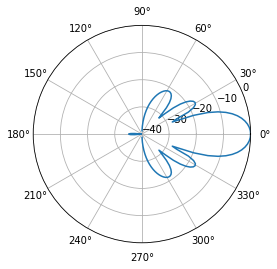

In [26]:
plt.figure()
a0 = plt.subplot(111, projection='polar')
plt.plot(angles, dirnlty)
plt.ylim(-40,0);plt.yticks([0,-10,-20,-30,-40]);
plt.xticks(np.radians(np.arange(0,360,30)));